# Knowledge Distillation: GPT-2 → TinyTransformer
This notebook demonstrates how to train a small transformer (student) to mimic GPT-2 (teacher) on a next-token prediction task using knowledge distillation.

**Task**: Language Modeling (Next Token Prediction)

**Teacher**: GPT-2

**Student**: Custom 4-layer Transformer

**Dataset**: WikiText-2 (subset)

In [3]:
!pip install -q torch torchvision matplotlib


In [7]:
!pip install fsspec==2023.6.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.6.0 which is incompatible.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Load GPT-2 Teacher

In [8]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
teacher = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
teacher.eval()

# Load and Preprocess WikiText-2

In [9]:
# 2. Load and tokenize WikiText-2
raw_dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_texts = [t for t in raw_dataset['train']['text'] if len(t.strip()) > 30][:5000]

class WikiDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_len=32):
        self.samples = []
        for t in texts:
            ids = tokenizer(t, return_tensors="pt", truncation=True,
                            max_length=seq_len+1, padding="max_length")['input_ids'].squeeze(0)
            self.samples.append((ids[:-1], ids[1:]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

train_ds = WikiDataset(train_texts, tokenizer)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

# Define TinyTransformer Student

In [10]:
# 3. Define a Tiny Transformer student
class TinyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=4, num_layers=4, ff_dim=512):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        encoder = nn.TransformerEncoderLayer(d_model, nhead, ff_dim)
        self.transformer = nn.TransformerEncoder(encoder, num_layers)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)
        return self.lm_head(x)

student = TinyTransformer(len(tokenizer)).to(device)
optimizer = optim.Adam(student.parameters(), lr=5e-4)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# Train Student with Knowledge Distillation

In [20]:
# 4. Distillation training setup
T = 2.0
alpha = 0.7

def distillation_loss(student_logits, teacher_logits, target):
    loss_soft = F.kl_div(
        F.log_softmax(student_logits / T, dim=-1),
        F.softmax(teacher_logits / T, dim=-1),
        reduction='batchmean'
    ) * (T * T)
    loss_hard = F.cross_entropy(student_logits.view(-1, student_logits.size(-1)), target.view(-1))
    return alpha * loss_soft + (1 - alpha) * loss_hard

# 5. Training loop with logging
losses, entropies, kls, accs = [], [], [], []

for epoch in range(25):
    total_loss, total_kl, total_entropy, total_acc = 0, 0, 0, 0
    student.train()
    for x, y in tqdm(train_dl, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            teacher_logits = teacher(x).logits

        student_logits = student(x)

        loss = distillation_loss(student_logits, teacher_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        kl = F.kl_div(
            F.log_softmax(student_logits / T, dim=-1),
            F.softmax(teacher_logits / T, dim=-1),
            reduction='batchmean'
        ).item()
        entropy = -(F.softmax(student_logits, dim=-1) * F.log_softmax(student_logits, dim=-1)).sum(-1).mean().item()

        pred = student_logits.argmax(dim=-1)
        acc = (pred == y).float().mean().item()

        total_loss += loss.item()
        total_kl += kl
        total_entropy += entropy
        total_acc += acc

    avg_loss = total_loss / len(train_dl)
    avg_kl = total_kl / len(train_dl)
    avg_entropy = total_entropy / len(train_dl)
    avg_acc = total_acc / len(train_dl)

    losses.append(avg_loss)
    kls.append(avg_kl)
    entropies.append(avg_entropy)
    accs.append(avg_acc)
    print(f"Loss: {avg_loss:.4f}, KL: {avg_kl:.4f}, Entropy: {avg_entropy:.4f}, Accuracy: {avg_acc:.4f}")

Epoch 1: 100%|██████████| 625/625 [00:34<00:00, 18.31it/s]


Loss: 32.5383, KL: 11.1005, Entropy: 5.1784, Accuracy: 0.2822


Epoch 2: 100%|██████████| 625/625 [00:33<00:00, 18.90it/s]


Loss: 31.8047, KL: 10.8430, Entropy: 5.1733, Accuracy: 0.2848


Epoch 3: 100%|██████████| 625/625 [00:33<00:00, 18.80it/s]


Loss: 31.0598, KL: 10.5814, Entropy: 5.1666, Accuracy: 0.2873


Epoch 4: 100%|██████████| 625/625 [00:33<00:00, 18.66it/s]


Loss: 30.4691, KL: 10.3740, Entropy: 5.1673, Accuracy: 0.2905


Epoch 5: 100%|██████████| 625/625 [00:33<00:00, 18.80it/s]


Loss: 29.9657, KL: 10.1977, Entropy: 5.1638, Accuracy: 0.2925


Epoch 6: 100%|██████████| 625/625 [00:33<00:00, 18.79it/s]


Loss: 29.4500, KL: 10.0161, Entropy: 5.1572, Accuracy: 0.2939


Epoch 7: 100%|██████████| 625/625 [00:33<00:00, 18.78it/s]


Loss: 29.0481, KL: 9.8750, Entropy: 5.1551, Accuracy: 0.2961


Epoch 8: 100%|██████████| 625/625 [00:33<00:00, 18.71it/s]


Loss: 28.6115, KL: 9.7211, Entropy: 5.1538, Accuracy: 0.2976


Epoch 9: 100%|██████████| 625/625 [00:33<00:00, 18.77it/s]


Loss: 28.3303, KL: 9.6226, Entropy: 5.1492, Accuracy: 0.2990


Epoch 10: 100%|██████████| 625/625 [00:33<00:00, 18.79it/s]


Loss: 28.0352, KL: 9.5186, Entropy: 5.1426, Accuracy: 0.3004


Epoch 11: 100%|██████████| 625/625 [00:33<00:00, 18.76it/s]


Loss: 27.7166, KL: 9.4063, Entropy: 5.1436, Accuracy: 0.3008


Epoch 12: 100%|██████████| 625/625 [00:33<00:00, 18.75it/s]


Loss: 27.4166, KL: 9.3007, Entropy: 5.1385, Accuracy: 0.3024


Epoch 13: 100%|██████████| 625/625 [00:33<00:00, 18.79it/s]


Loss: 27.1301, KL: 9.2002, Entropy: 5.1369, Accuracy: 0.3028


Epoch 14: 100%|██████████| 625/625 [00:33<00:00, 18.81it/s]


Loss: 26.8966, KL: 9.1180, Entropy: 5.1354, Accuracy: 0.3049


Epoch 15: 100%|██████████| 625/625 [00:33<00:00, 18.75it/s]


Loss: 26.7002, KL: 9.0492, Entropy: 5.1315, Accuracy: 0.3056


Epoch 16: 100%|██████████| 625/625 [00:33<00:00, 18.81it/s]


Loss: 26.4712, KL: 8.9686, Entropy: 5.1286, Accuracy: 0.3064


Epoch 17: 100%|██████████| 625/625 [00:33<00:00, 18.72it/s]


Loss: 26.3104, KL: 8.9116, Entropy: 5.1319, Accuracy: 0.3058


Epoch 18: 100%|██████████| 625/625 [00:33<00:00, 18.80it/s]


Loss: 26.0959, KL: 8.8360, Entropy: 5.1227, Accuracy: 0.3071


Epoch 19: 100%|██████████| 625/625 [00:33<00:00, 18.85it/s]


Loss: 25.9490, KL: 8.7845, Entropy: 5.1238, Accuracy: 0.3084


Epoch 20: 100%|██████████| 625/625 [00:33<00:00, 18.77it/s]


Loss: 25.7530, KL: 8.7158, Entropy: 5.1215, Accuracy: 0.3092


Epoch 21: 100%|██████████| 625/625 [00:33<00:00, 18.81it/s]


Loss: 25.5872, KL: 8.6574, Entropy: 5.1199, Accuracy: 0.3089


Epoch 22: 100%|██████████| 625/625 [00:33<00:00, 18.72it/s]


Loss: 25.4832, KL: 8.6209, Entropy: 5.1173, Accuracy: 0.3103


Epoch 23: 100%|██████████| 625/625 [00:33<00:00, 18.81it/s]


Loss: 25.2989, KL: 8.5558, Entropy: 5.1126, Accuracy: 0.3117


Epoch 24: 100%|██████████| 625/625 [00:33<00:00, 18.78it/s]


Loss: 25.1645, KL: 8.5088, Entropy: 5.1119, Accuracy: 0.3117


Epoch 25: 100%|██████████| 625/625 [00:33<00:00, 18.80it/s]

Loss: 25.0350, KL: 8.4630, Entropy: 5.1080, Accuracy: 0.3120


# Visualize Training Metrics

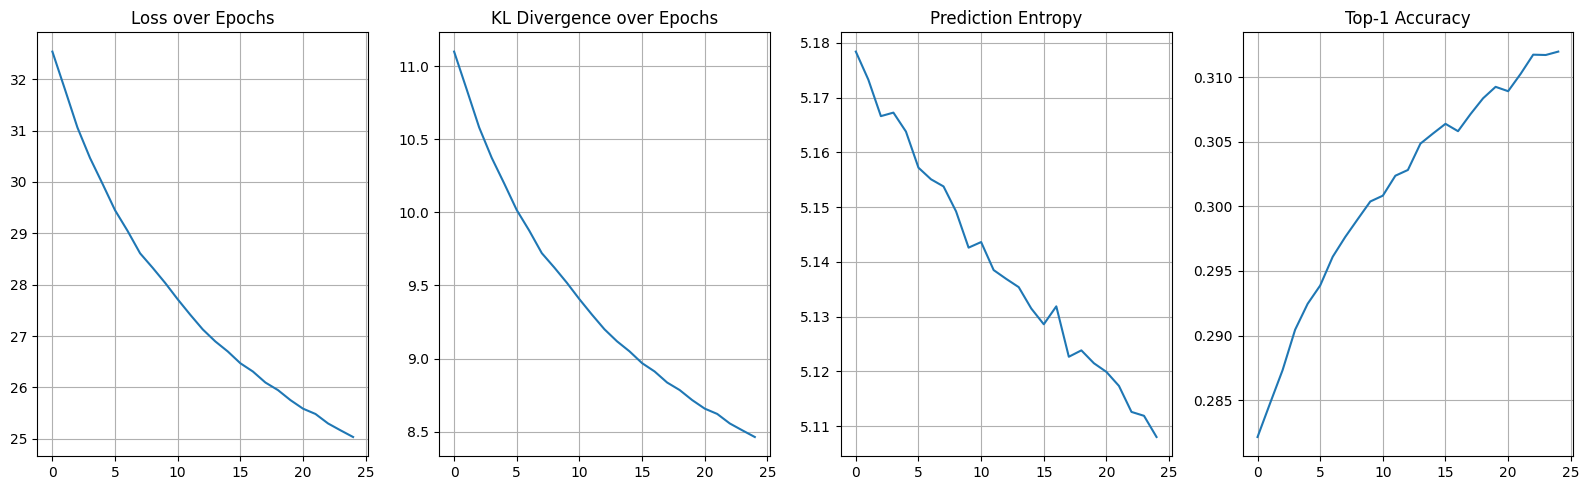

In [21]:

# 6. Plotting trends
plt.figure(figsize=(16, 5))
plt.subplot(1, 4, 1)
plt.plot(losses, label='Distillation Loss')
plt.title("Loss over Epochs")
plt.grid(True)
plt.subplot(1, 4, 2)
plt.plot(kls, label='KL Divergence')
plt.title("KL Divergence over Epochs")
plt.grid(True)
plt.subplot(1, 4, 3)
plt.plot(entropies, label='Entropy')
plt.title("Prediction Entropy")
plt.grid(True)
plt.subplot(1, 4, 4)
plt.plot(accs, label='Student Accuracy')
plt.title("Top-1 Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Compare Predictions for a Token

In [22]:
# 7. Token-wise Softmax Distribution Comparison

def visualize_prediction(sentence, token_index):
    inputs = tokenizer(sentence, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        teacher_out = teacher(inputs).logits
        student_out = student(inputs)

    t_probs = F.softmax(teacher_out[0, token_index], dim=-1).cpu().numpy()
    s_probs = F.softmax(student_out[0, token_index], dim=-1).cpu().numpy()
    topk = np.argsort(t_probs)[-10:]

    labels = [tokenizer.decode([i]) for i in topk]
    t_vals = t_probs[topk]
    s_vals = s_probs[topk]

    x = np.arange(len(labels))
    plt.figure(figsize=(10, 5))
    plt.bar(x - 0.2, t_vals, 0.4, label='Teacher')
    plt.bar(x + 0.2, s_vals, 0.4, label='Student')
    plt.xticks(x, labels, rotation=45)
    plt.title(f"Prediction at token {token_index}: '{tokenizer.decode([inputs[0, token_index].item()])}'")
    plt.legend()
    plt.tight_layout()
    plt.show()


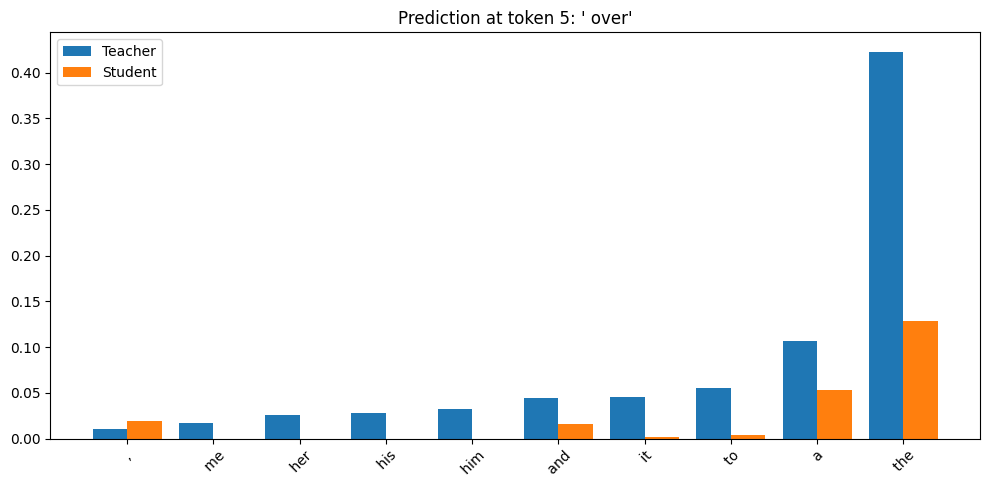

In [46]:
# 8. Visualize Prediction Entropy Distribution
import seaborn as sns

def plot_entropy_distribution():
    student.eval()
    entropies = []
    for x, _ in train_dl:
        x = x.to(device)
        with torch.no_grad():
            logits = student(x)
            probs = F.softmax(logits, dim=-1)
            ent = -(probs * torch.log(probs + 1e-9)).sum(-1)
            entropies.extend(ent.view(-1).cpu().numpy())

    sns.histplot(entropies, kde=True, bins=50)
    plt.title("Distribution of Student Prediction Entropy")
    plt.xlabel("Entropy")
    plt.ylabel("Token Count")
    plt.grid(True)
    plt.show()

# Call this after training for deeper insight:
visualize_prediction("The quick brown fox jumps over the lazy", token_index=5)



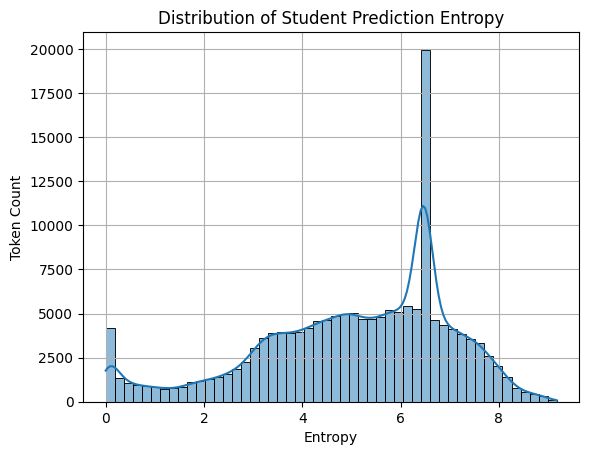

In [15]:
plot_entropy_distribution()

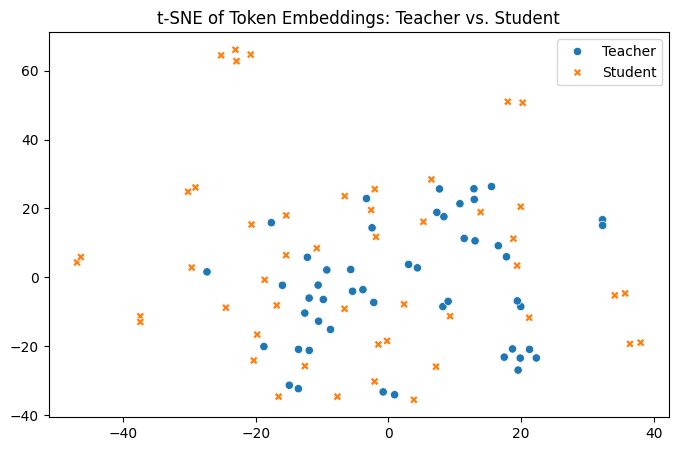

In [45]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_tsne(input_text):
    inputs = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        t_emb = teacher.transformer.wte(inputs).squeeze(0).cpu().numpy()  # [seq, 768]
        s_emb = student.embed(inputs).squeeze(0).cpu().numpy()            # [seq, 256]

    # Reduce both to 64D using PCA
    pca = PCA(n_components=8)
    t_reduced = pca.fit_transform(t_emb)
    s_reduced = pca.fit_transform(s_emb)

    # Stack and apply t-SNE
    combined = np.concatenate([t_reduced, s_reduced], axis=0)
    labels = ['Teacher'] * len(t_reduced) + ['Student'] * len(s_reduced)

    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    reduced = tsne.fit_transform(combined)

    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, style=labels)
    plt.title("t-SNE of Token Embeddings: Teacher vs. Student")
    plt.show()


visualize_tsne("The quick brown fox jumps over the lazy")
